# Ebola model

## Import libraries

In [1]:
import numpy as np
import pandas as pd

from Scripts import SimulatSEIR_expanded
from Scripts import HMMSEIR_expanded
from Scripts import MCMCSEIR_expanded
from Scripts import EMSEIR

import matplotlib.pyplot as plt

from scipy.stats import binom

## Simulation from the Ebola model

We show how to simulate artificially some epidemics from the Ebola model. We set the parameters to the ones suggested in "Statistical Inference in a Stochastic Epidemic SEIR Model with Control Intervention: Ebola as a Case Study" by Phenyo E. Lekone and Bairbel F. Finkenstaidt.

### Set the parameters

In [2]:
#parameters from Lekone and FInkenstadt 2006 Ebola paper
T = 212
N     = 5364501
beta  = 0.21
rho   = 1/5
gamma = 1/7

q_r = 0.2
t_star = 130

#eta_zero = np.array([5364500/N, 0, 1/N, 0])
eta_zero = np.array([5364500/5364501, 1/5364501, 0, 0]) #paper uses an even smaller I_0 than this
q = np.zeros((4,4))

q[1,2] = 291/316   #accounting for under-reporting as in the paper
q[2,3] = 236/316   #

SEIR_sim = SimulatSEIR_expanded.SEIR_expanded(N, beta, rho, gamma, q_r, t_star)

### Simulate the epidemic and plot

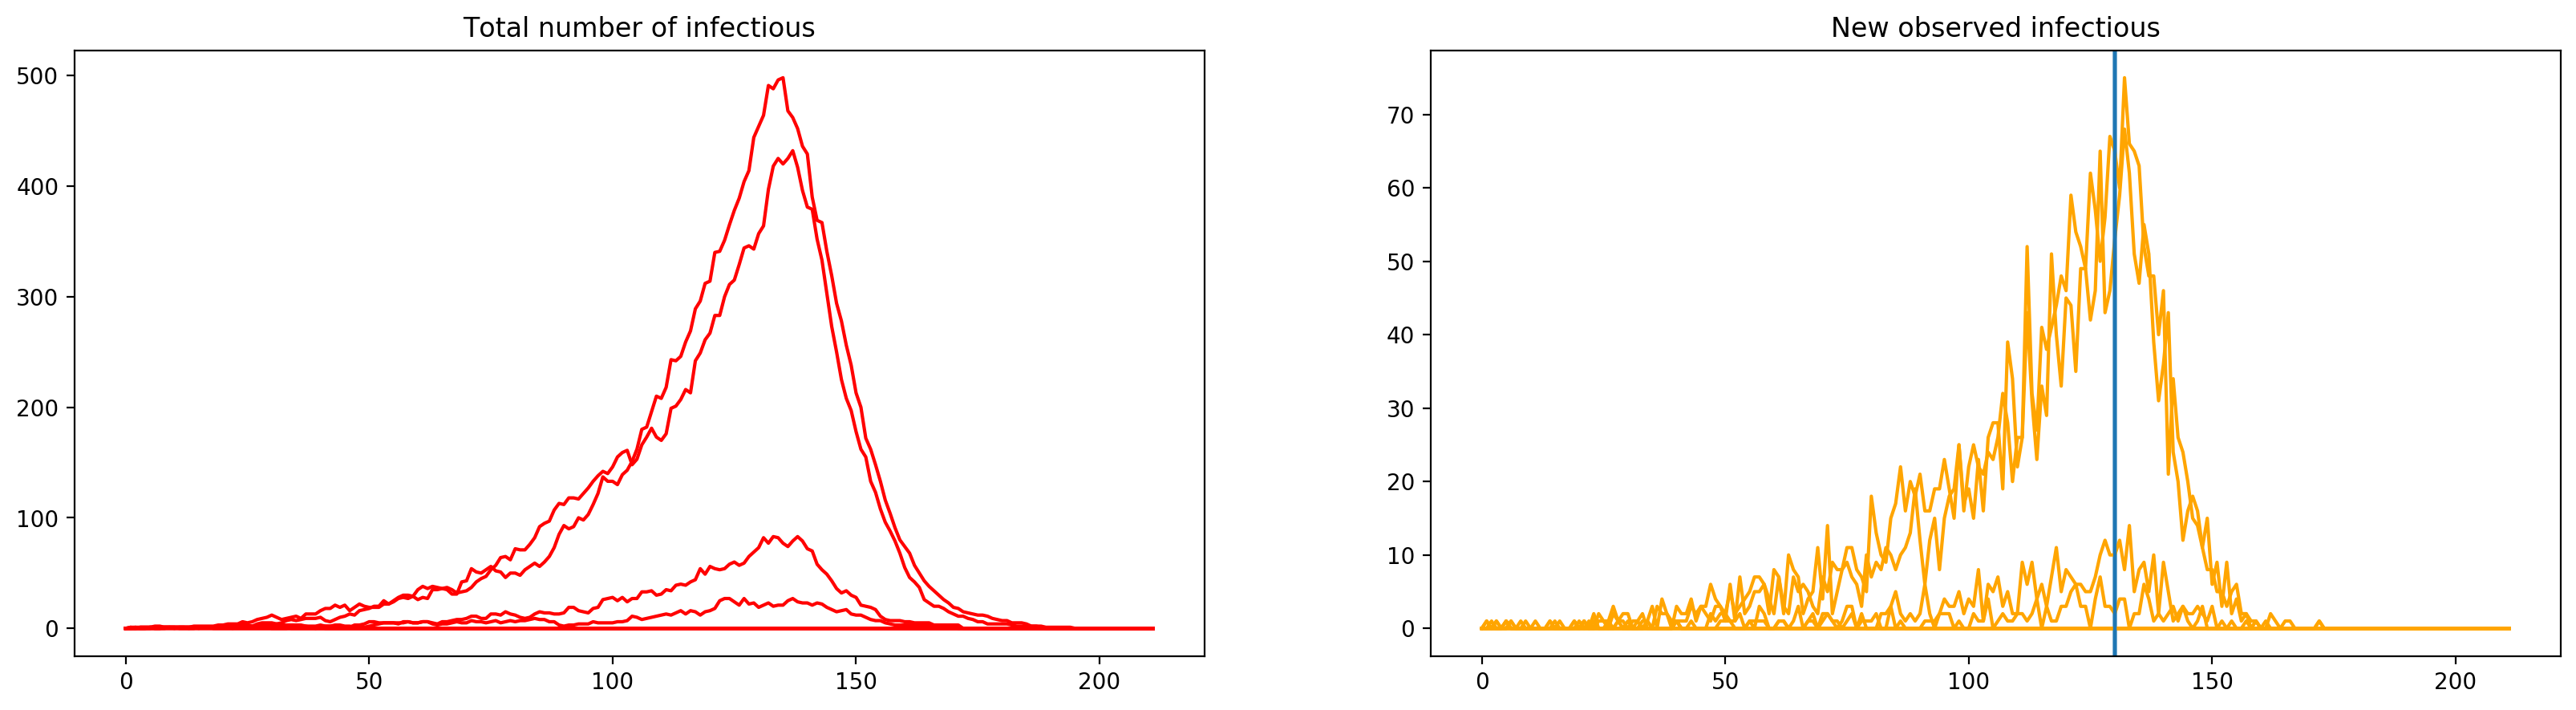

In [3]:
np.random.seed(789)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=200)

ax1.set_title("Total number of infectious")
ax2.set_title("New observed infectious")

for i in range(0, 10):
    # simulation1 is the true value of the compartments, y are our observations
    simulation1, y = SEIR_sim.Evolution(eta_zero, T, q)
    
    ax1.plot(simulation1[2,:], color = "red")
    
    ax2.plot(y[1,2,:], color = "orange")
    plt.axvline(130)

    # plt.plot(simulation1_norest[0,:], color = "green", linestyle = "--", label = r"No restr $X_t^S$")
    # plt.plot(simulation1_norest[1,:], color = "orange", linestyle = "--", label = r"No restr $X_t^E$")
    # plt.plot(simulation1_norest[2,:], color = "red", linestyle = "--", label = r"No restr $X_t^I$")
    # plt.plot(simulation1_norest[3,:], color = "blue", linestyle = "--", label = r"No restr $X_t^R$")
# plt.legend()
plt.show()

## Multinomial approximation

Given the simulated data, we show how to use the multinomial approximation code to extract filtering and smoothing distributions with the corresponding 95%-credible intervals.

### Set the parameters

In [4]:
HMM_expanded = HMMSEIR_expanded.HMM_approxSEIR_expanded(N, beta, rho, gamma, q, eta_zero, q_r, t_star)

### Filtering distribution and credible intervals

In [5]:
pitt, _, pitt_expanded, _ = HMM_expanded.filtering(y)

Compute the credible intervals

In [6]:
p_I = np.zeros(T)
upper_I = np.zeros(T)
lower_I = np.zeros(T)
comp_ind = 1

alpha = 0.05

for t in range(T):

    p_I[t] = pitt[comp_ind,t] #smoothing distribution
    upper_I[t] = binom.ppf(1-alpha/2 , N, p_I[t]) 
    lower_I[t] = binom.ppf(alpha/2 , N, np.maximum(p_I[t],1e-12) ) #maximu to overcome bug in binom.ppf  
    
p_R = np.zeros(T)
upper_R = np.zeros(T)
lower_R = np.zeros(T)
comp_ind = 2

alpha = 0.05

for t in range(T):

    p_R[t] = pitt[comp_ind,t] #smoothing distribution
    upper_R[t] = binom.ppf(1-alpha/2 , N, p_R[t]) 
    lower_R[t] = binom.ppf(alpha/2 , N, np.maximum(p_R[t],1e-12) ) #maximu to overcome bug in binom.ppf  

Plot the results

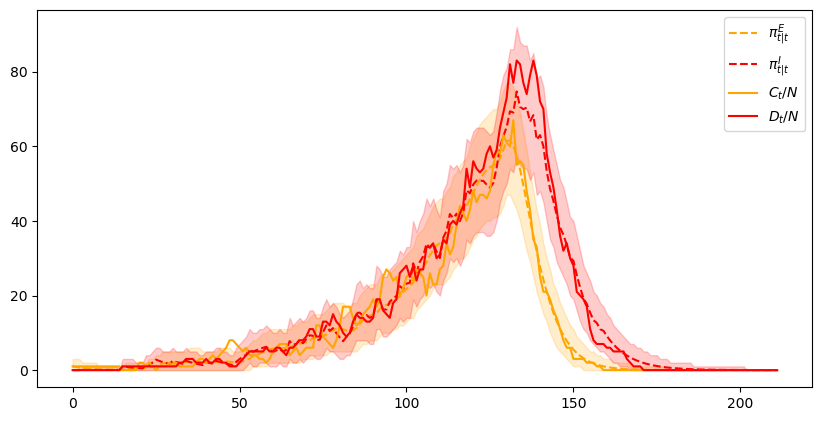

In [7]:
fig, ax = plt.subplots(1,1, figsize = (10, 5), dpi =100, sharey=True)

ax.plot(N*pitt[1,:], color = "orange", linestyle = "--", label = r"$\pi_{t|t}^E$")
ax.plot(N*pitt[2,:], color = "red", linestyle = "--", label = r"$\pi_{t|t}^I$")

ax.fill_between(range(T), lower_I, upper_I, alpha=0.2, color = "orange")
ax.fill_between(range(T), lower_R, upper_R, alpha=0.2, color = "red")

ax.plot(simulation1[1,:], color = "orange", label = r"$C_t/N$")
ax.plot(simulation1[2,:], color = "red", label = r"$D_t/N$")

ax.legend()

### Smoothing distribution and credible intervals

In [8]:
pist, pist_expanded = HMM_expanded.smoothing(pitt_expanded, pitt)

Compute the credible intervals

In [9]:
p_I = np.zeros(T)
upper_I = np.zeros(T)
lower_I = np.zeros(T)
comp_ind = 1

alpha = 0.05

for t in range(T):

    p_I[t] = pist[comp_ind,t] #smoothing distribution
    upper_I[t] = binom.ppf(1-alpha/2 , N, p_I[t]) 
    lower_I[t] = binom.ppf(alpha/2 , N, np.maximum(p_I[t],1e-12) ) #maximu to overcome bug in binom.ppf  
    
p_R = np.zeros(T)
upper_R = np.zeros(T)
lower_R = np.zeros(T)
comp_ind = 2

alpha = 0.05

for t in range(T):

    p_R[t] = pist[comp_ind,t] #smoothing distribution
    upper_R[t] = binom.ppf(1-alpha/2 , N, p_R[t]) 
    lower_R[t] = binom.ppf(alpha/2 , N, np.maximum(p_R[t],1e-12) ) #maximu to overcome bug in binom.ppf  

Plot the results (the smoothing distribution is closer to the true value of the compartment)

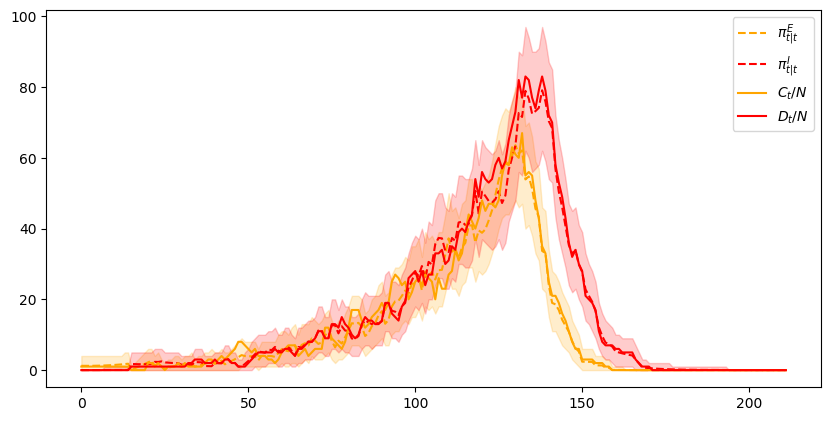

In [10]:
fig, ax = plt.subplots(1,1, figsize = (10, 5), dpi =100, sharey=True)

ax.plot(N*pist[1,:], color = "orange", linestyle = "--", label = r"$\pi_{t|t}^E$")
ax.plot(N*pist[2,:], color = "red", linestyle = "--", label = r"$\pi_{t|t}^I$")

ax.fill_between(range(T), lower_I, upper_I, alpha=0.2, color = "orange")
ax.fill_between(range(T), lower_R, upper_R, alpha=0.2, color = "red")

ax.plot(simulation1[1,:], color = "orange", label = r"$C_t/N$")
ax.plot(simulation1[2,:], color = "red", label = r"$D_t/N$")

ax.legend()

## MCMC on sythetic data from the Ebola model

Run a Metropolis within Gibbs to estimate the parameters $\beta, \lambda, \gamma, \rho, q$

### Set the parameters

In [11]:
seed = 321

#parameters from Lekone and FInkenstadt 2006 Ebola paper
T = 193
N     = 5364501
t_star = 130

# Set the initial conditions
np.random.seed(seed)
beta_0  = np.random.gamma(20, 1/100)        
rho_0   = np.random.gamma(20, 1/100)   
gamma_0 = np.random.gamma(20, 1/140) 

q_r_0 = np.random.gamma(2, 1/10)  

eta_zero_0 = np.array([5364500/5364501, 1/5364501, 0,0]) #paper uses an even smaller I_0 than this
x_0 = np.array([1, 1, 1, 1])

q_0 = np.zeros((4,4))
q_0[1,2] = np.random.uniform(0.5, 1)   #accounting for under-reporting as in the paper
q_0[2,3] = np.random.uniform(0.5, 1)   #

# Set the priors (this is the informative case)
beta_prior = np.array([ 20, 100])
rho_prior = np.array([  20, 100])
gamma_prior = np.array([20, 140])
q_r_prior = np.array([ 2, 10])

q_prior= np.array([1, 1])

# deprecated we do not learn the initial distribution, but potentially we could
eta_zero_prior = np.array([1, 1, 1, 1])


#Set the proposal
beta_proposal_variance = 0.03
rho_proposal_variance = 0.06
gamma_proposal_variance = 0.03
q_r_proposal_variance = 0.09

q_proposal_variance = 0.08

### Run the MCMC 

it took around 10min on a 4 cores Intel(R) Core(TM) i7-7700HQ CPU @2.80GHz

In [12]:
# MCMC
MCMC = MCMCSEIR_expanded.MCMC_SEIR_expanded(N, t_star, beta_prior, rho_prior, gamma_prior, q_prior, q_r_prior, eta_zero_prior, beta_proposal_variance, rho_proposal_variance, gamma_proposal_variance, q_proposal_variance, q_r_proposal_variance)

np.random.seed(seed)

sample_size = 10000
beta_chain, rho_chain, gamma_chain, eta_zero_chain, q_chain, x_chain, q_r_chain = MCMC.posterior_sample( sample_size, y, beta_0, rho_0, gamma_0, eta_zero_0, x_0, q_0, q_r_0)


Iteration: 100
Acceptance ratio beta: 0.25
Acceptance ratio rho: 0.4
Acceptance ratio gamma: 0.24
Acceptance ratio q_r: 0.29
Acceptance ratio q: 0.38
Acceptance ratio eta: 0.0
Iteration: 200
Acceptance ratio beta: 0.27
Acceptance ratio rho: 0.375
Acceptance ratio gamma: 0.215
Acceptance ratio q_r: 0.37
Acceptance ratio q: 0.36
Acceptance ratio eta: 0.0
Iteration: 300
Acceptance ratio beta: 0.2866666666666667
Acceptance ratio rho: 0.37666666666666665
Acceptance ratio gamma: 0.22333333333333333
Acceptance ratio q_r: 0.36
Acceptance ratio q: 0.36333333333333334
Acceptance ratio eta: 0.0
Iteration: 400
Acceptance ratio beta: 0.2775
Acceptance ratio rho: 0.3975
Acceptance ratio gamma: 0.25
Acceptance ratio q_r: 0.3275
Acceptance ratio q: 0.3375
Acceptance ratio eta: 0.0
Iteration: 500
Acceptance ratio beta: 0.278
Acceptance ratio rho: 0.404
Acceptance ratio gamma: 0.23
Acceptance ratio q_r: 0.318
Acceptance ratio q: 0.342
Acceptance ratio eta: 0.0
Iteration: 600
Acceptance ratio beta: 0.288

Iteration: 3800
Acceptance ratio beta: 0.2710526315789474
Acceptance ratio rho: 0.3792105263157895
Acceptance ratio gamma: 0.23710526315789474
Acceptance ratio q_r: 0.3360526315789474
Acceptance ratio q: 0.31894736842105265
Acceptance ratio eta: 0.0
Iteration: 3900
Acceptance ratio beta: 0.2735897435897436
Acceptance ratio rho: 0.37846153846153846
Acceptance ratio gamma: 0.23897435897435898
Acceptance ratio q_r: 0.3371794871794872
Acceptance ratio q: 0.31794871794871793
Acceptance ratio eta: 0.0
Iteration: 4000
Acceptance ratio beta: 0.27325
Acceptance ratio rho: 0.378
Acceptance ratio gamma: 0.2395
Acceptance ratio q_r: 0.33775
Acceptance ratio q: 0.31625
Acceptance ratio eta: 0.0
Iteration: 4100
Acceptance ratio beta: 0.275609756097561
Acceptance ratio rho: 0.37682926829268293
Acceptance ratio gamma: 0.23902439024390243
Acceptance ratio q_r: 0.33682926829268295
Acceptance ratio q: 0.31585365853658537
Acceptance ratio eta: 0.0
Iteration: 4200
Acceptance ratio beta: 0.2714285714285714


Iteration: 7200
Acceptance ratio beta: 0.27291666666666664
Acceptance ratio rho: 0.36819444444444444
Acceptance ratio gamma: 0.24375
Acceptance ratio q_r: 0.35944444444444446
Acceptance ratio q: 0.3209722222222222
Acceptance ratio eta: 0.0
Iteration: 7300
Acceptance ratio beta: 0.2719178082191781
Acceptance ratio rho: 0.3667123287671233
Acceptance ratio gamma: 0.24342465753424658
Acceptance ratio q_r: 0.3591780821917808
Acceptance ratio q: 0.3206849315068493
Acceptance ratio eta: 0.0
Iteration: 7400
Acceptance ratio beta: 0.27175675675675676
Acceptance ratio rho: 0.36783783783783786
Acceptance ratio gamma: 0.2431081081081081
Acceptance ratio q_r: 0.3587837837837838
Acceptance ratio q: 0.3210810810810811
Acceptance ratio eta: 0.0
Iteration: 7500
Acceptance ratio beta: 0.2708
Acceptance ratio rho: 0.3682666666666667
Acceptance ratio gamma: 0.2424
Acceptance ratio q_r: 0.3586666666666667
Acceptance ratio q: 0.3212
Acceptance ratio eta: 0.0
Iteration: 7600
Acceptance ratio beta: 0.27157894

### Traceplots, histograms and estimates

In [13]:
Gibbs_data = {}

k=0
    
Gibbs_data[str(k)] = {}

beta_MCMC  = beta_chain 
q_r_MCMC   = q_r_chain  
rho_MCMC   = rho_chain  
gamma_MCMC = gamma_chain
q_MCMC     = q_chain    

Gibbs_data[str(k)]["beta"] = beta_MCMC
Gibbs_data[str(k)]["rho"]  = rho_MCMC
Gibbs_data[str(k)]["gamma"]= gamma_MCMC
Gibbs_data[str(k)]["q_r"]  = q_r_MCMC
Gibbs_data[str(k)]["q"]  = q_MCMC

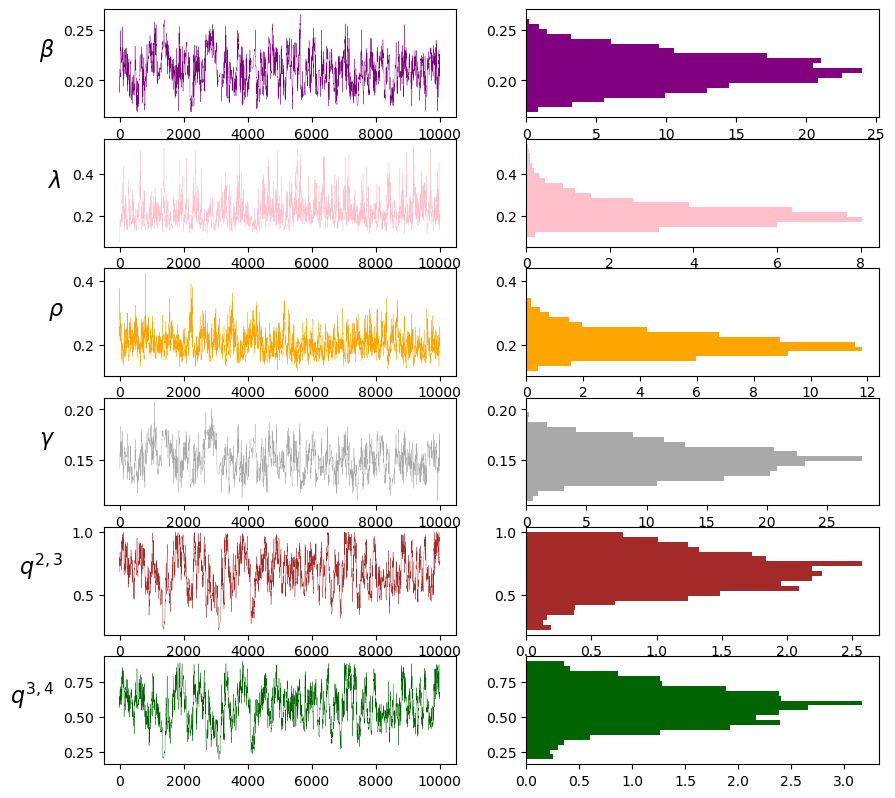

In [14]:
colors = ["purple", "pink", "orange", "darkgrey", "brown", "darkgreen"] 
labels = [r"$\beta$    ", r"$\lambda$    ", r"$\rho$    ", r"$\gamma$    ", r"$q^{2,3}$        ", r"$q^{3,4}$        "]
keys = ["beta", "q_r", "rho", "gamma", "q"]


fig, ax = plt.subplots(6,2, figsize = (10, 10), dpi =100)

for i in range(0,6): # use 6 for the eta
        
    for j in range(0, 1):
        if j==0:
            ax[i,j].set_ylabel(labels[i], fontsize=16, rotation =0)
            

        if i<4:
            ax[i,j].plot(Gibbs_data[str(j)][keys[i]], color = colors[i], linewidth=0.25)
            ax[i,2*j+1].hist(Gibbs_data[str(j)][keys[i]], color = colors[i], orientation="horizontal", bins = 20, density =True)
            ax[i,j].xaxis.set_tick_params(labelsize=10)
            ax[i,j].yaxis.set_tick_params(labelsize=10)
        else:
            ax[i,j].plot(Gibbs_data[str(j)][keys[4]][i-3,i-3+1,:], color = colors[i], linewidth=0.25)
            ax[i,2*j+1].hist(Gibbs_data[str(j)][keys[4]][i-3,i-3+1,:], color = colors[i], orientation="horizontal", bins = 20, density =True)
            ax[i,j].xaxis.set_tick_params(labelsize=10)
            ax[i,j].yaxis.set_tick_params(labelsize=10)
    


In [15]:
spaces = ["       ", " ", " ", "         ","   ","   ",]
    
print("MCMC using metropolis within gibbs")
for j in range(0, 1): # use 6 for eta
    string = ""
    for i in range(0, 4):
        string = string + keys[i]+" "+ str(np.round(np.mean(Gibbs_data[str(j)][keys[i]]), 3))+" "+ "("+ str(np.round(np.std(Gibbs_data[str(j)][keys[i]]),4))+ "); "
    
    string = string + keys[4]+"_12 "+ str(np.round(np.mean(Gibbs_data[str(j)][keys[4]][1,2,:]), 3))+ "("+ str(np.round(np.std(Gibbs_data[str(j)][keys[4]][1,2,:]),4))+ "); "
    string = string + keys[4]+"_23 "+ str(np.round(np.mean(Gibbs_data[str(j)][keys[4]][2,3,:]), 3))+ "("+ str(np.round(np.std(Gibbs_data[str(j)][keys[4]][2,3,:]),4))+ "); "
    
    r_0 = Gibbs_data[str(j)]["beta"]/Gibbs_data[str(j)]["gamma"]
    string = string + "R_0 "+ str(np.round(np.mean(r_0),3)) +"("+str(np.round(np.std(r_0),4))+")" 
    print(string)

MCMC using metropolis within gibbs
beta 0.21 (0.0165); q_r 0.216 (0.0611); rho 0.205 (0.0358); gamma 0.15 (0.0146); q_12 0.68(0.1579); q_23 0.572(0.1364); R_0 1.402(0.077)


## EM algorithm on sythetic data from the Ebola model

We show how to use the EM algortihm. The data are the same of the MCMC.

### Set the parameters

In [16]:
beta_prior = np.array([0,0])
#setting the second argument to 0 gives a flat prior, first argument does nothing
rho_prior = np.array([0,0])
gamma_prior = np.array([0,0])

n_grid = 5
beta_grid = np.linspace(0.01,0.4,n_grid)
q_r_grid = np.linspace(0.01,0.4,n_grid)

rho_out = np.zeros([n_grid,n_grid])
gamma_out = np.zeros([n_grid,n_grid])
q_out = np.zeros([4,4,n_grid,n_grid])
init_pop_out = np.zeros([4,n_grid, n_grid])
log_like_out = np.zeros([n_grid,n_grid])

### Run the EM

We envaluate $\beta$ and $\lambda$ on a grid and we learn the other parameters from the EM algorithm.

In [17]:
n_iter = 100

for i in range(n_grid):
    #EM = EM_approxSEIR(N, beta_grid[i], 2, 1, q.copy(), init_pop.copy(), y, 0)
    for j in range(n_grid):
        print('i =', i, 'j =',j)
        EM = EMSEIR.EM_approxSEIR_expanded(N, beta_grid[i], rho_0, gamma_0,  q_0, eta_zero_0, q_r_grid[j], t_star, y, 0, 
                               beta_prior, rho_prior, gamma_prior)
    
        beta_est, rho_est, gamma_est, q_est, init_pop_est, log_like_out[i,j] = EM.iterate(n_iter)
    
        rho_out[i,j] = rho_est[-1]
        gamma_out[i,j] = gamma_est[-1]
        q_out[:,:,i,j] = q_est[:,:,-1]
        init_pop_out[:,i,j] = init_pop_est[:,-1]

i = 0 j = 0
i = 0 j = 1
i = 0 j = 2
i = 0 j = 3
i = 0 j = 4
i = 1 j = 0
i = 1 j = 1
i = 1 j = 2
i = 1 j = 3
i = 1 j = 4
i = 2 j = 0
i = 2 j = 1
i = 2 j = 2
i = 2 j = 3
i = 2 j = 4
i = 3 j = 0
i = 3 j = 1
i = 3 j = 2
i = 3 j = 3
i = 3 j = 4
i = 4 j = 0
i = 4 j = 1
i = 4 j = 2
i = 4 j = 3
i = 4 j = 4


We report the combination with the highest likelihood 

In [18]:
i_max = np.unravel_index(np.argmax(log_like_out, axis=None), log_like_out.shape)

print('index of best fitting beta, q_r = ', i_max)

print('beta_grid =', beta_grid)
print('q_r_grid =',  q_r_grid)


print('beta =',beta_grid[i_max[0]])
print('rho =',rho_out[i_max[0], i_max[1]])
print('gamma =',gamma_out[i_max[0], i_max[1]])
print('q_r =',q_r_grid[i_max[1]])

index of best fitting beta, q_r =  (2, 1)
beta_grid = [0.01   0.1075 0.205  0.3025 0.4   ]
q_r_grid = [0.01   0.1075 0.205  0.3025 0.4   ]
beta = 0.20500000000000002
rho = 0.42370413032047277
gamma = 0.1620380440120805
q_r = 0.1075


## MCMC on the 1995 Ebola outbreak data

### Set the parameters

Load the data and set the main parameters

In [21]:
data = pd.read_csv("Data/EBOLA.csv", sep =";")
ebola_I = data["onset"].values
ebola_R = data["death"].values

# Start the count from 1st March
first_march = 54

T_end = np.size(ebola_I)

y = np.zeros((4,4, np.size(ebola_I)-first_march+1))

y[1, 2, :] = ebola_I[first_march-1:]
y[2, 3, :] = ebola_R[first_march-1:]

# epidemic time in number of days counting from 1st March
T = np.size(ebola_I)-first_march+1 

# population size
N     = 5364501
# control measurements in days counting from 1st March
t_star = 70
# initial population as in Lekone
eta_zero = np.array([5364500/5364501, 1/5364501, 0, 0]) #paper uses an even smaller I_0 than this

Plot the data

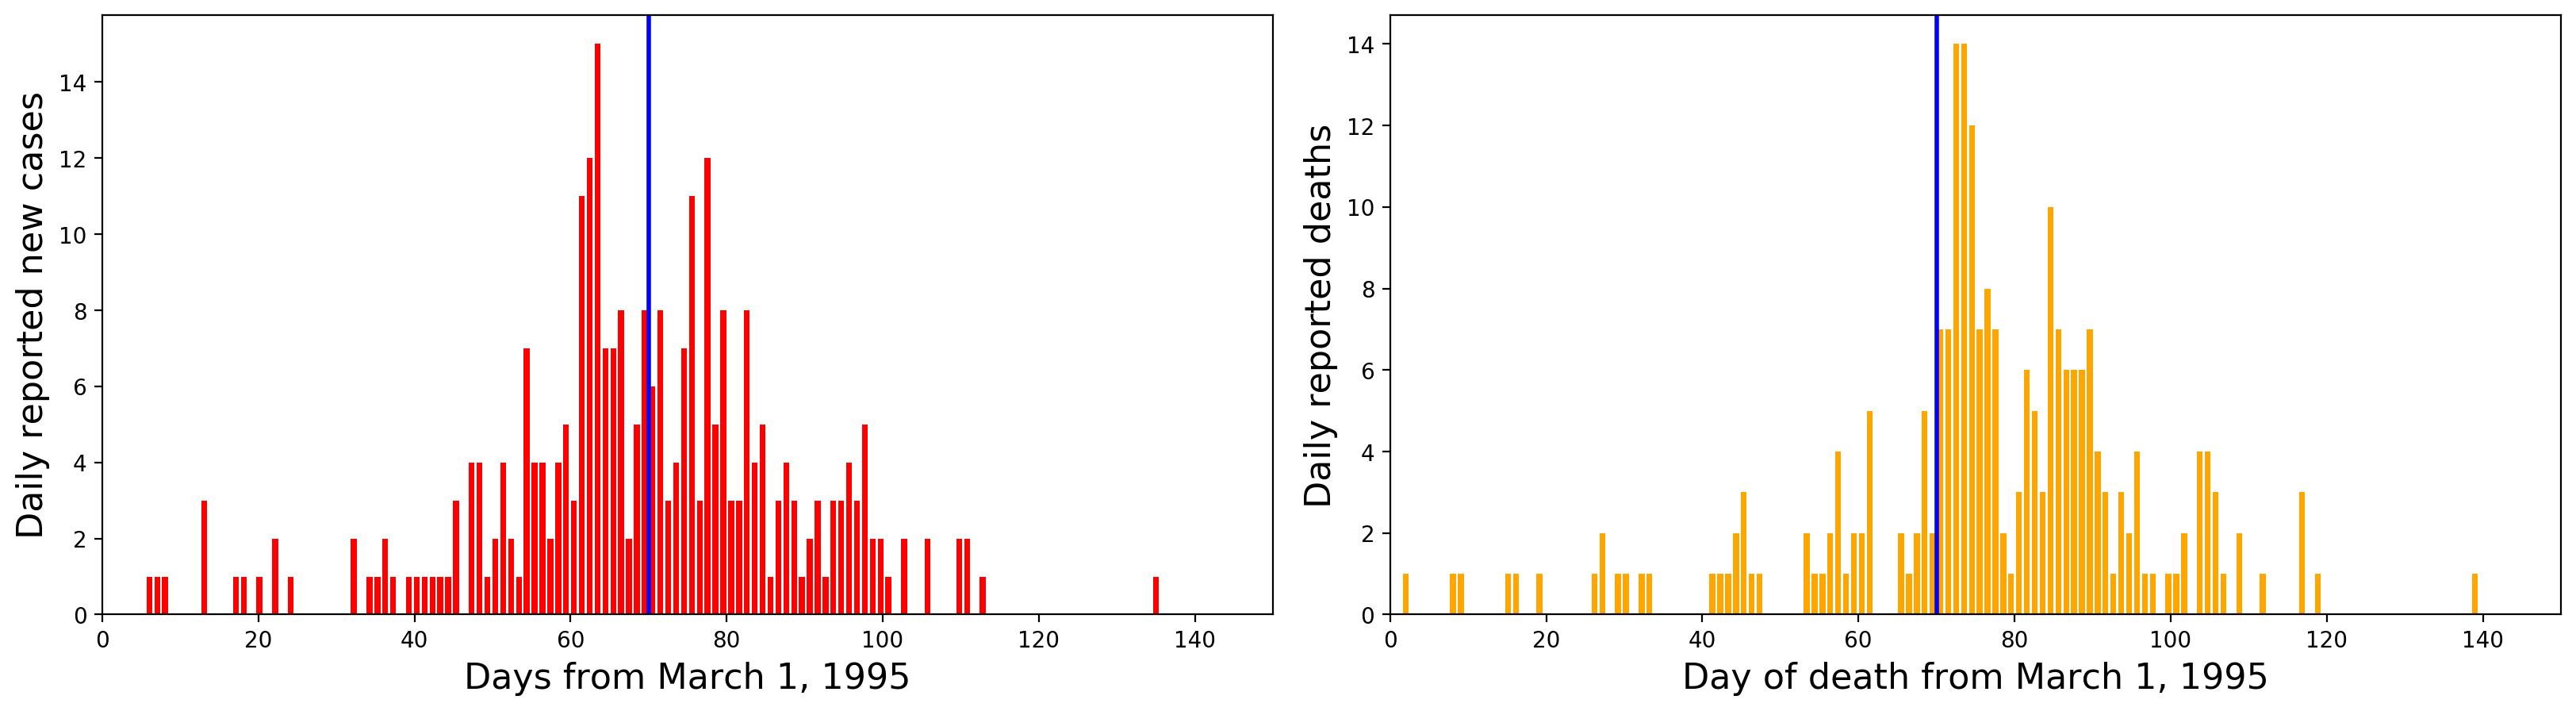

In [22]:
# separate
# two separate pictures
import matplotlib.gridspec as gridspec


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0)

ax1.set_xlabel('Days from March 1, 1995', fontsize=16)
ax1.set_ylabel('Daily reported new cases', fontsize=16)

ax2.set_xlabel('Day of death from March 1, 1995', fontsize=16)
ax2.set_ylabel('Daily reported deaths', fontsize=16)

ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)

ax2.xaxis.set_tick_params(labelsize=10)
ax2.yaxis.set_tick_params(labelsize=10)

ax1.set_xlim((0, 150))
ax2.set_xlim((0, 150))

ax1.bar(np.linspace(1, len(ebola_I[53:]), len(ebola_I[first_march:])), ebola_I[first_march:], color = "red", label = r"Infectious", width = 0.75)
ax2.bar(np.linspace(1, len(ebola_R[53:]), len(ebola_R[first_march:])), ebola_R[first_march:], color = "orange", label = r"Removed", width = 0.75)

ax1.axvline(t_star, color = "blue", label = "Control measures", linewidth =2)
ax2.axvline(t_star, color = "blue", label = "Control measures", linewidth =2)

# ax1.legend(loc='upper right', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)

Set the remaining parameters

In [23]:
# Set the initial conditions
np.random.seed(seed)
beta_0  = 0.37     
rho_0   = 0.092   
gamma_0 = 0.16

q_0 = np.zeros((4,4))
q_0[1,2] = 291/316 #accounting for under-reporting as in the paper
q_0[2,3] = 236/316 #

q_r_0 = 0.368  

eta_zero_0 = np.array([5364500/5364501, 1/5364501, 0,0]) #paper uses an even smaller I_0 than this
x_0 = np.array([1, 1, 1, 1])

# Set the priors
beta_prior = np.array([ 2, 10])
rho_prior = np.array([  2, 10])
gamma_prior = np.array([2, 14])
q_r_prior = np.array([ 2, 10])

q_prior= np.array([1, 1])

eta_zero_prior = np.array([1, 1, 1, 1])


#Set the proposal
beta_proposal_variance = 0.03
rho_proposal_variance = 0.02
gamma_proposal_variance = 0.02
q_r_proposal_variance = 0.2

q_proposal_variance = 0.07

### Run the MCMC

It took around 10min on a 4 cores Intel(R) Core(TM) i7-7700HQ CPU @2.80GHz).Remark that $10^5$ iterations is not enough to get stationarity, we recommend using at least $10^6$.

In [24]:
# MCMC
MCMC_EBOLA = MCMCSEIR_expanded.MCMC_SEIR_expanded(N, t_star, beta_prior, rho_prior, gamma_prior, q_prior, q_r_prior, eta_zero_prior, beta_proposal_variance, rho_proposal_variance, gamma_proposal_variance, q_proposal_variance, q_r_proposal_variance)

np.random.seed(seed)

sample_size = 10000
beta_chain, rho_chain, gamma_chain, eta_zero_chain, q_chain, x_chain, q_r_chain = MCMC_EBOLA.posterior_sample( sample_size, y, beta_0, rho_0, gamma_0, eta_zero_0, x_0, q_0, q_r_0)



Iteration: 100
Acceptance ratio beta: 0.41
Acceptance ratio rho: 0.35
Acceptance ratio gamma: 0.4
Acceptance ratio q_r: 0.32
Acceptance ratio q: 0.43
Acceptance ratio eta: 0.0
Iteration: 200
Acceptance ratio beta: 0.41
Acceptance ratio rho: 0.325
Acceptance ratio gamma: 0.37
Acceptance ratio q_r: 0.375
Acceptance ratio q: 0.365
Acceptance ratio eta: 0.0
Iteration: 300
Acceptance ratio beta: 0.38666666666666666
Acceptance ratio rho: 0.32666666666666666
Acceptance ratio gamma: 0.33666666666666667
Acceptance ratio q_r: 0.30333333333333334
Acceptance ratio q: 0.3233333333333333
Acceptance ratio eta: 0.0
Iteration: 400
Acceptance ratio beta: 0.38
Acceptance ratio rho: 0.3125
Acceptance ratio gamma: 0.3075
Acceptance ratio q_r: 0.3
Acceptance ratio q: 0.2925
Acceptance ratio eta: 0.0
Iteration: 500
Acceptance ratio beta: 0.38
Acceptance ratio rho: 0.304
Acceptance ratio gamma: 0.336
Acceptance ratio q_r: 0.31
Acceptance ratio q: 0.288
Acceptance ratio eta: 0.0
Iteration: 600
Acceptance ratio

Iteration: 3800
Acceptance ratio beta: 0.3676315789473684
Acceptance ratio rho: 0.32105263157894737
Acceptance ratio gamma: 0.3513157894736842
Acceptance ratio q_r: 0.34657894736842104
Acceptance ratio q: 0.27052631578947367
Acceptance ratio eta: 0.0
Iteration: 3900
Acceptance ratio beta: 0.36666666666666664
Acceptance ratio rho: 0.31974358974358974
Acceptance ratio gamma: 0.3517948717948718
Acceptance ratio q_r: 0.34512820512820513
Acceptance ratio q: 0.27205128205128204
Acceptance ratio eta: 0.0
Iteration: 4000
Acceptance ratio beta: 0.3685
Acceptance ratio rho: 0.32175
Acceptance ratio gamma: 0.3525
Acceptance ratio q_r: 0.3405
Acceptance ratio q: 0.2745
Acceptance ratio eta: 0.0
Iteration: 4100
Acceptance ratio beta: 0.36804878048780487
Acceptance ratio rho: 0.32390243902439025
Acceptance ratio gamma: 0.35292682926829266
Acceptance ratio q_r: 0.33902439024390246
Acceptance ratio q: 0.27658536585365856
Acceptance ratio eta: 0.0
Iteration: 4200
Acceptance ratio beta: 0.36714285714285

Iteration: 7200
Acceptance ratio beta: 0.3630555555555556
Acceptance ratio rho: 0.32125
Acceptance ratio gamma: 0.36736111111111114
Acceptance ratio q_r: 0.34
Acceptance ratio q: 0.2743055555555556
Acceptance ratio eta: 0.0
Iteration: 7300
Acceptance ratio beta: 0.3628767123287671
Acceptance ratio rho: 0.3198630136986301
Acceptance ratio gamma: 0.3680821917808219
Acceptance ratio q_r: 0.34054794520547943
Acceptance ratio q: 0.27493150684931505
Acceptance ratio eta: 0.0
Iteration: 7400
Acceptance ratio beta: 0.3622972972972973
Acceptance ratio rho: 0.32
Acceptance ratio gamma: 0.3677027027027027
Acceptance ratio q_r: 0.34175675675675676
Acceptance ratio q: 0.2762162162162162
Acceptance ratio eta: 0.0
Iteration: 7500
Acceptance ratio beta: 0.3628
Acceptance ratio rho: 0.3197333333333333
Acceptance ratio gamma: 0.3678666666666667
Acceptance ratio q_r: 0.34186666666666665
Acceptance ratio q: 0.2769333333333333
Acceptance ratio eta: 0.0
Iteration: 7600
Acceptance ratio beta: 0.3628947368421

### Traceplots, histograms and estimates

In [25]:
Ebola_data = {}

for k in range(0,1):
    
    Ebola_data[str(k)] = {}
        
    Ebola_data[str(k)]["beta"] = beta_chain
    Ebola_data[str(k)]["rho"]  = q_r_chain
    Ebola_data[str(k)]["gamma"]= rho_chain
    Ebola_data[str(k)]["q_r"]  = gamma_chain
    Ebola_data[str(k)]["q"]    = q_chain

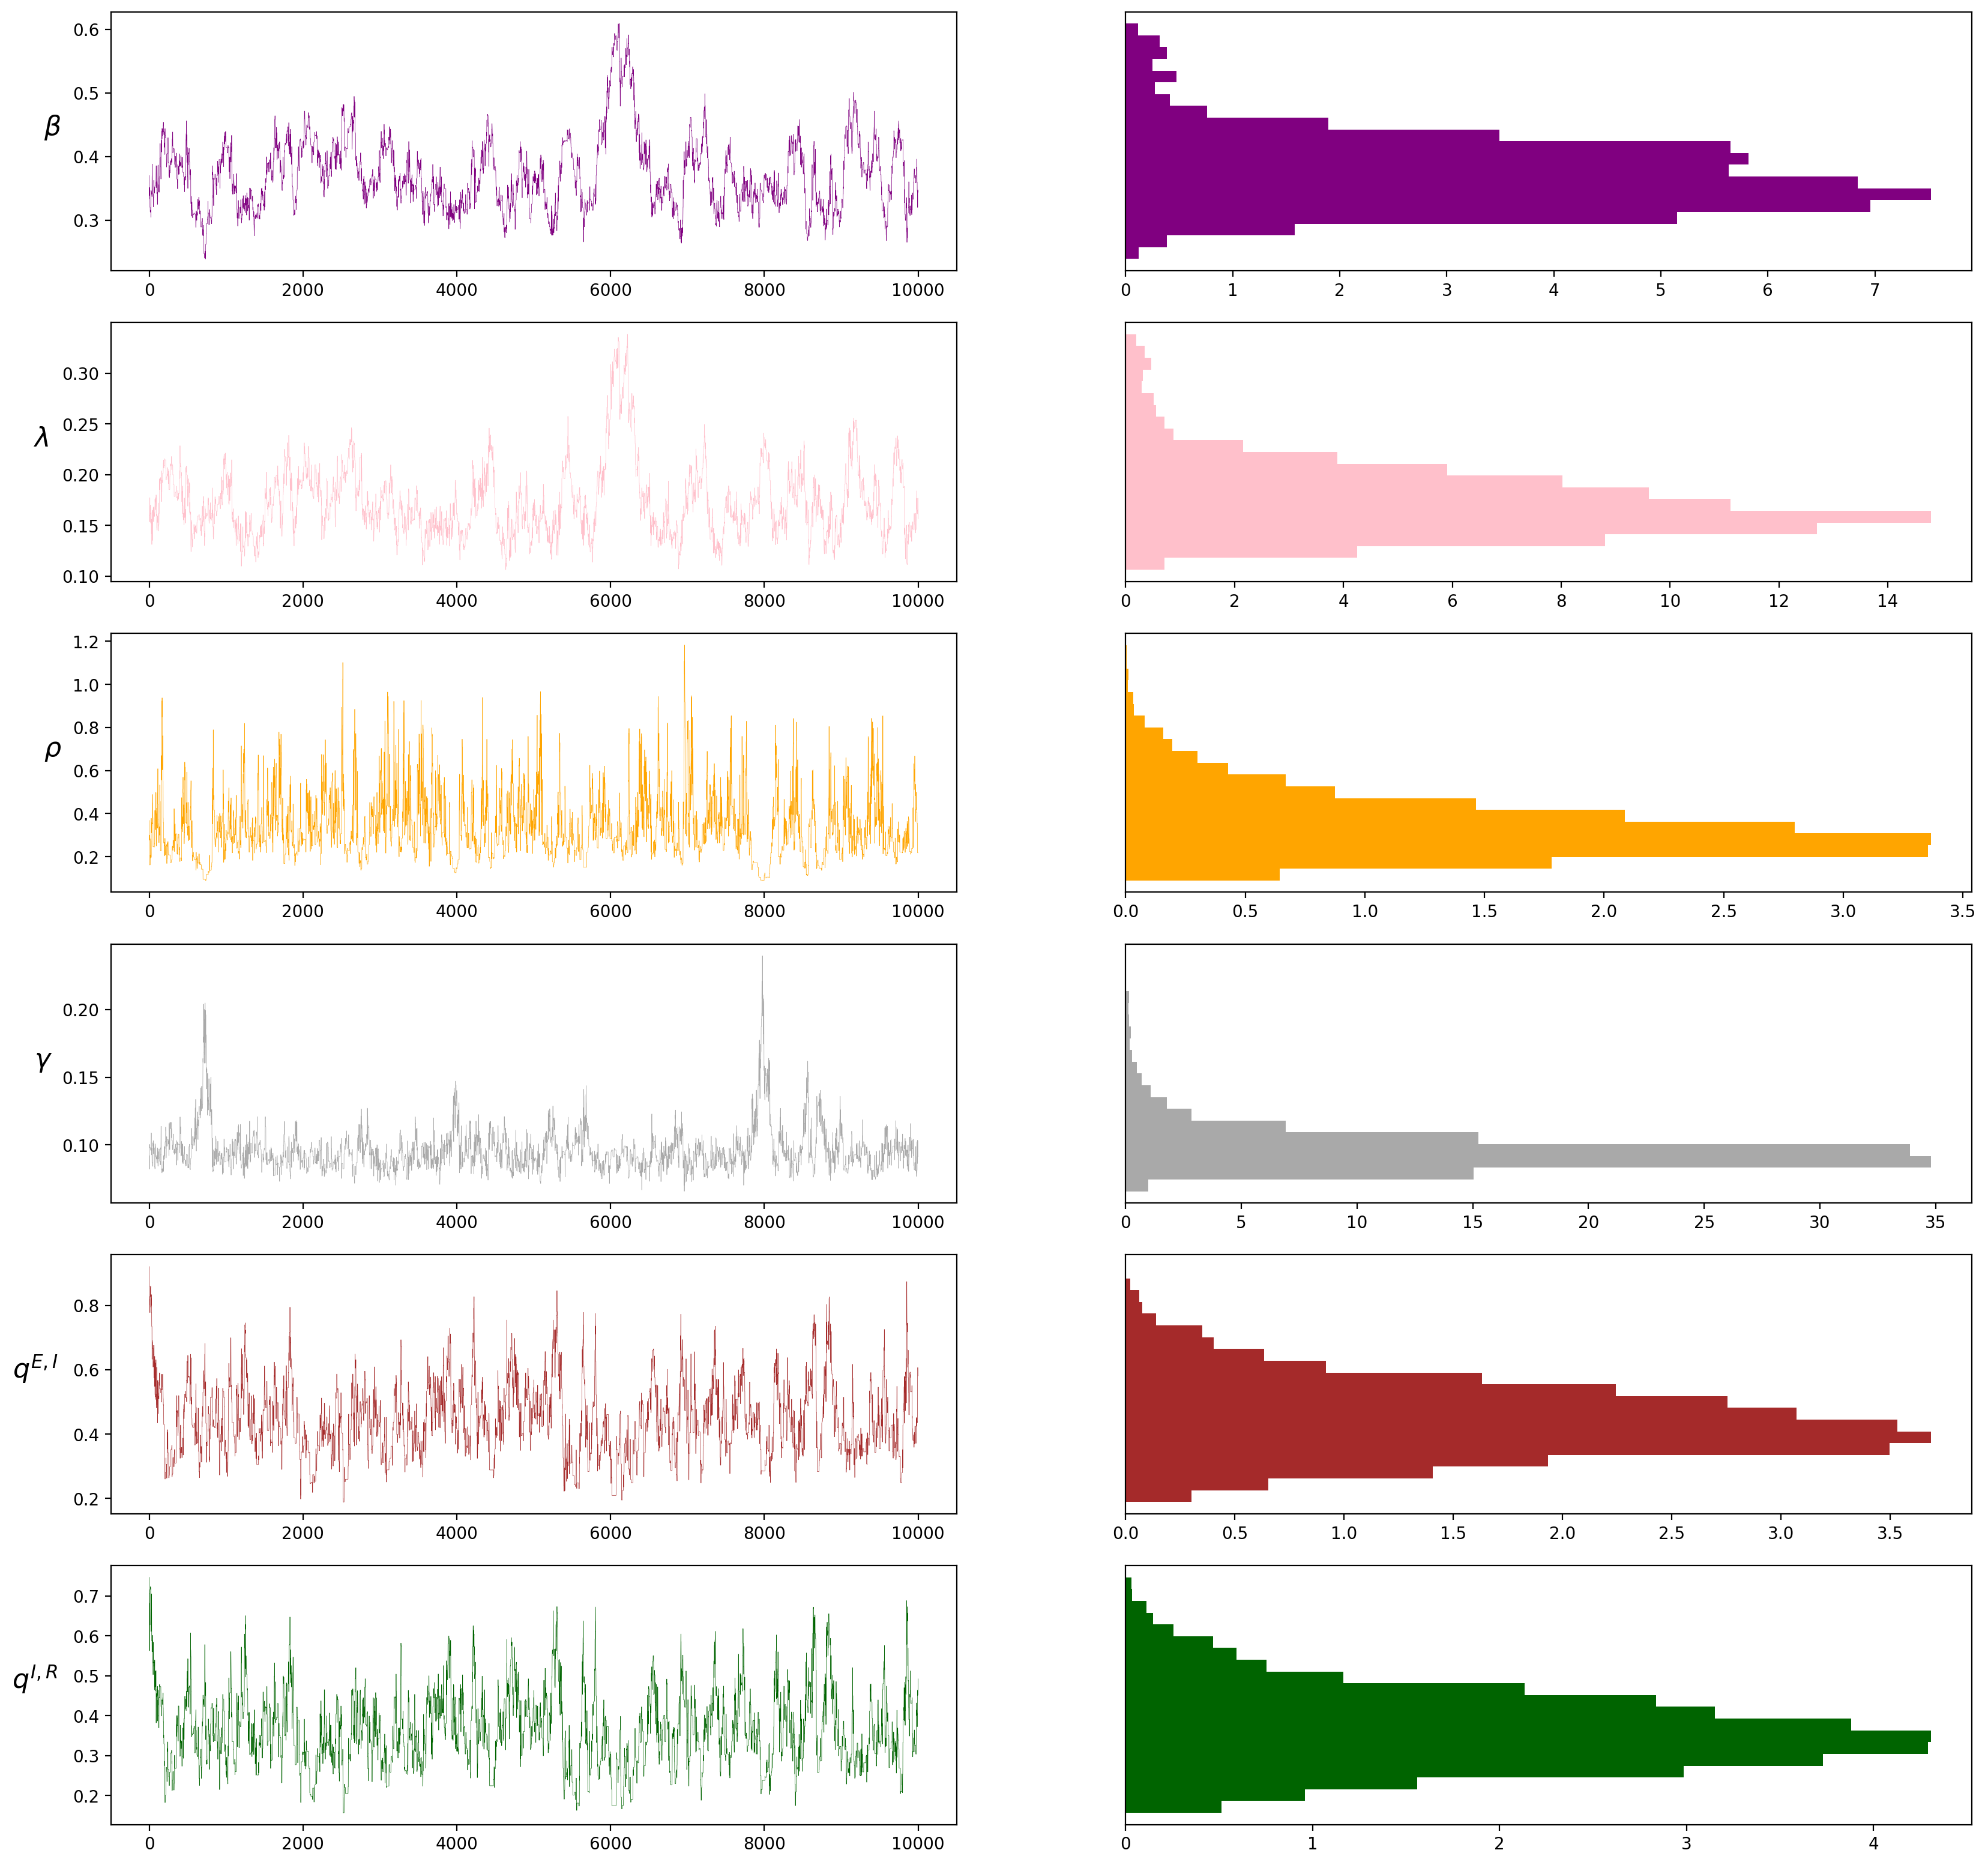

In [26]:
colors = ["purple", "pink", "orange", "darkgrey", "brown", "darkgreen"] 
labels = [r"$\beta$    ", r"$\lambda$    ", r"$\rho$    ", r"$\gamma$    ", r"$q^{E,I}$        ", r"$q^{I,R}$        "]
keys = ["beta", "q_r", "rho", "gamma", "q"]


fig, ax = plt.subplots(6,2, figsize = (20, 20), dpi =200)

for i in range(0,6): # use 6 for the eta
        
    for j in range(0, 1):
        
        if j==0:
            ax[i,2*j].set_ylabel(labels[i], fontsize=16, rotation =0)
            

        if i<4:
            ax[i,2*j].plot(Ebola_data[str(j)][keys[i]], color = colors[i], linewidth=0.25)
            ax[i,2*j+1].hist(Ebola_data[str(j)][keys[i]], color = colors[i], orientation="horizontal", bins = 20, density =True)
            ax[i,2*j+1].set_yticks([], [])
            ax[i,2*j].xaxis.set_tick_params(labelsize=10)
            ax[i,2*j].yaxis.set_tick_params(labelsize=10)
        else:
            ax[i,2*j].plot(Ebola_data[str(j)][keys[4]][i-3,i-3+1,:], color = colors[i], linewidth=0.25)
            ax[i,2*j+1].hist(Ebola_data[str(j)][keys[4]][i-3,i-3+1,:], color = colors[i], orientation="horizontal", bins = 20, density =True)
            ax[i,2*j+1].set_yticks([], [])
            ax[i,2*j].xaxis.set_tick_params(labelsize=10)
            ax[i,2*j].yaxis.set_tick_params(labelsize=10)


In [27]:
spaces = ["       ", " ", " ", "         ","   ","   ",]
    
print("MCMC using metropolis within gibbs")
for j in range(0, 1): # use 6 for eta
    string = ""
    for i in range(0, 4):
        string = string + keys[i]+" "+ str(np.round(np.mean(Ebola_data[str(j)][keys[i]]), 3))+" "+ "("+ str(np.round(np.std(Ebola_data[str(j)][keys[i]]),4))+ "); "
    
    string = string + keys[4]+"_12 "+ str(np.round(np.mean(Ebola_data[str(j)][keys[4]][1,2,:]), 3))+ "("+ str(np.round(np.std(Ebola_data[str(j)][keys[4]][1,2,:]),4))+ "); "
    string = string + keys[4]+"_23 "+ str(np.round(np.mean(Ebola_data[str(j)][keys[4]][2,3,:]), 3))+ "("+ str(np.round(np.std(Ebola_data[str(j)][keys[4]][2,3,:]),4))+ "); "
    
    r_0 = Ebola_data[str(j)]["beta"]/Ebola_data[str(j)]["gamma"]
    string = string + "R_0 "+ str(np.round(np.mean(r_0),3)) +"("+str(np.round(np.std(r_0),4))+")" 
    print(string)

MCMC using metropolis within gibbs
beta 0.372 (0.0569); q_r 0.173 (0.0355); rho 0.337 (0.145); gamma 0.096 (0.0161); q_12 0.442(0.1119); q_23 0.363(0.0952); R_0 3.986(0.934)
